In [3]:
# import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx

import warnings
import sys
import os
warnings.filterwarnings("ignore")
sys.stderr = open(os.devnull, 'w')

# local crs
local_crs = 32636
# path to data

## Препроцессинг данных

In [5]:
graph = nx.read_graphml('/Users/mvin/Code/PopFrame/examples/data/graph.graphml')
graph_crs = graph.graph['crs']
okrugs = gpd.read_parquet('/Users/mvin/Code/PopFrame/examples/data/model_data/okrugs.parquet')
rayons = gpd.read_parquet('/Users/mvin/Code/PopFrame/examples/data/model_data/rayons.parquet')
territories = gpd.read_file('/Users/mvin/Code/PopFrame/examples/data/territories/shlis.geojson').to_crs(graph_crs)
towns = gpd.read_file('/Users/mvin/Code/PopFrame/examples/data/towns.geojson').to_crs(graph_crs)

In [6]:
towns


,municipal district,municipality,name,rural settlement,fid,centre,geometry
0,Бокситогорский муниципальный район,Борское сельское поселение,Болото,деревня,None,None,POINT (543142.339 6580637.744)
1,Бокситогорский муниципальный район,Борское сельское поселение,Большой Остров,деревня,None,None,POINT (544532.929 6593228.214)
2,Бокситогорский муниципальный район,Борское сельское поселение,Бор,деревня (административный центр),None,административный центр,POINT (544895.402 6593052.876)
3,Бокситогорский муниципальный район,Борское сельское поселение,Бороватое,деревня,None,None,POINT (543993.111 6589582.121)
4,Бокситогорский муниципальный район,Борское сельское поселение,Бочево,деревня,None,None,POINT (538540.110 6576793.684)
...,...,...,...,...,...,...,...
2926,Тосненский муниципальный район,Трубникоборское сельское поселение,Апраксин Бор,деревня,None,None,POINT (399059.742 6560341.471)
2927,Тосненский муниципальный район,Трубникоборское сельское поселение,Александровка,деревня,None,None,POINT (403967.171 6562087.081)
2928,Тосненский муниципальный район,Трубникоборское сельское поселение,Большая Горка,деревня,None,None,POINT (413116.740 6573793.279)
2929,Тосненский муниципальный район,Трубникоборское сельское поселение,Дроздово,деревня,None,None,POINT (412458.032 6574811.307)


In [7]:
from popframe.preprocessing.level_filler import LevelFiller
level_filler = LevelFiller(towns=towns)
towns = level_filler.fill_levels()
towns

,geometry,name,rural_settlement,level
0,POINT (543142.339 6580637.744),Болото,деревня,Пятый уровень
1,POINT (544532.929 6593228.214),Большой Остров,деревня,Пятый уровень
2,POINT (544895.402 6593052.876),Бор,деревня (административный центр),Третий уровень
3,POINT (543993.111 6589582.121),Бороватое,деревня,Пятый уровень
4,POINT (538540.110 6576793.684),Бочево,деревня,Пятый уровень
...,...,...,...,...
2926,POINT (399059.742 6560341.471),Апраксин Бор,деревня,Пятый уровень
2927,POINT (403967.171 6562087.081),Александровка,деревня,Пятый уровень
2928,POINT (413116.740 6573793.279),Большая Горка,деревня,Пятый уровень
2929,POINT (412458.032 6574811.307),Дроздово,деревня,Пятый уровень


In [8]:
from popframe.preprocessing.adjacency_calculator import AdjacencyCalculator

try:
  adj_mx = pd.read_pickle('data/adj_mx.pickle')
except:
  from popframe.preprocessing.adjacency_calculator import AdjacencyCalculator
  blocks = towns.copy()
  blocks.geometry = blocks.geometry.buffer(0.01)
  ac = AdjacencyCalculator(blocks=blocks, graph=graph)
  adj_mx = ac.get_dataframe()

In [9]:
from popframe.preprocessing.population_filler import PopulationFiller

towns['is_city'] = towns['rural_settlement'].apply(lambda x : x.lower().find('город')>=0)
pf = PopulationFiller(units=okrugs, towns=towns, adjacency_matrix=adj_mx)
towns = pf.fill()
towns

,geometry,name,level,is_city,median_time,coef,coef_norm,population
0,POINT (543142.339 6580637.744),Болото,Пятый уровень,False,1069.8,0.000935,0.032603,111.0
1,POINT (544532.929 6593228.214),Большой Остров,Пятый уровень,False,1024.6,0.000976,0.034041,116.0
2,POINT (544895.402 6593052.876),Бор,Третий уровень,False,1023.4,0.000977,0.034081,116.0
3,POINT (543993.111 6589582.121),Бороватое,Пятый уровень,False,1039.3,0.000962,0.033560,114.0
4,POINT (538540.110 6576793.684),Бочево,Пятый уровень,False,1096.4,0.000912,0.031812,108.0
...,...,...,...,...,...,...,...,...
2926,POINT (399059.742 6560341.471),Апраксин Бор,Пятый уровень,False,725.9,0.001378,0.059011,96.0
2927,POINT (403967.171 6562087.081),Александровка,Пятый уровень,False,706.2,0.001416,0.060657,98.0
2928,POINT (413116.740 6573793.279),Большая Горка,Пятый уровень,False,690.9,0.001447,0.062000,100.0
2929,POINT (412458.032 6574811.307),Дроздово,Пятый уровень,False,686.1,0.001458,0.062434,101.0


## Создание модели


In [10]:
from popframe.models.region import Region

region = Region(
  towns=towns,
  settlements=okrugs, 
  districts=rayons, 
  accessibility_matrix=adj_mx,
  territories=territories
)

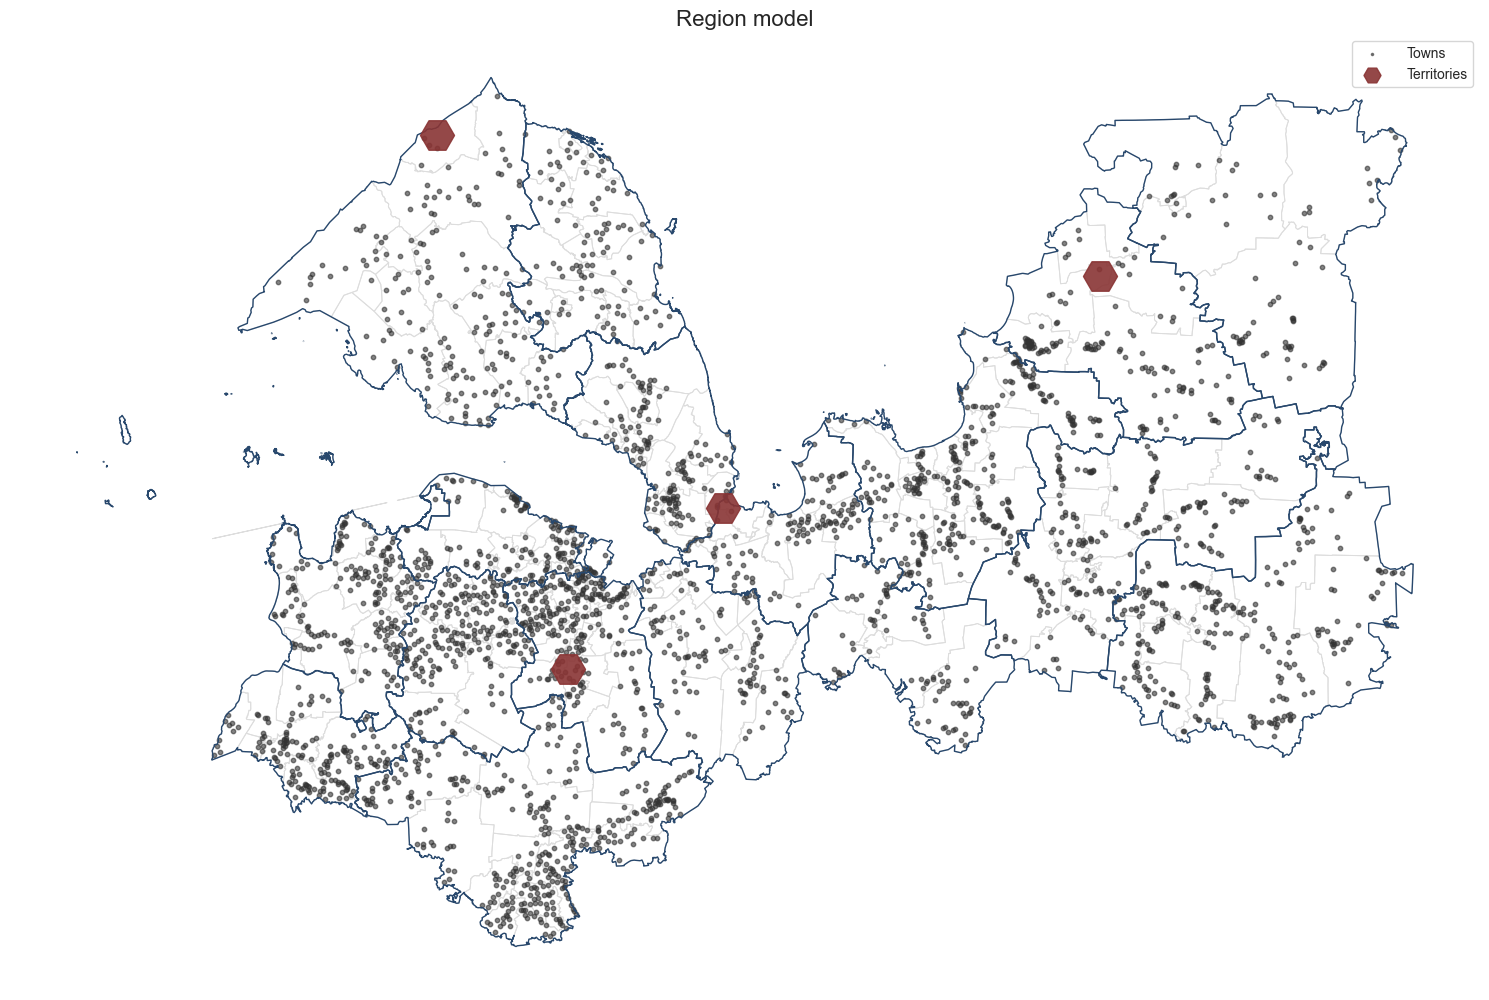

In [ ]:
region.plot()

In [ ]:
region.get_towns_gdf()

,id,name,population,level,geometry,settlement_name,district_name
0,0,Болото,111,Пятый уровень,POINT (543142.339 6580637.744),Борское сельское поселение,Бокситогорский муниципальный район
1,1,Большой Остров,116,Пятый уровень,POINT (544532.929 6593228.214),Борское сельское поселение,Бокситогорский муниципальный район
2,2,Бор,116,Третий уровень,POINT (544895.402 6593052.876),Борское сельское поселение,Бокситогорский муниципальный район
3,3,Бороватое,114,Пятый уровень,POINT (543993.111 6589582.121),Борское сельское поселение,Бокситогорский муниципальный район
4,4,Бочево,108,Пятый уровень,POINT (538540.110 6576793.684),Борское сельское поселение,Бокситогорский муниципальный район
...,...,...,...,...,...,...,...
2926,2926,Апраксин Бор,96,Пятый уровень,POINT (399059.742 6560341.471),Трубникоборское сельское поселение,Тоснненский муниципальный район
2927,2927,Александровка,98,Пятый уровень,POINT (403967.171 6562087.081),Трубникоборское сельское поселение,Тоснненский муниципальный район
2928,2928,Большая Горка,100,Пятый уровень,POINT (413116.740 6573793.279),Трубникоборское сельское поселение,Тоснненский муниципальный район
2929,2929,Дроздово,101,Пятый уровень,POINT (412458.032 6574811.307),Трубникоборское сельское поселение,Тоснненский муниципальный район


In [11]:
region.get_territories_gdf()

,name,geometry
id,,
0,Шиссельбург,"POLYGON ((387861.999 6644712.938, 388202.551 6..."


## Работа с моделью - Создание каркаса

In [12]:
from popframe.method.popuation_frame import PopFrame

In [13]:
# Создание экземпляра GraphMethod с данными
frame_method = PopFrame(region=region)

# Получение графа
G = frame_method.build_network()


In [14]:
num_edges = G.number_of_edges()
print("Количество рёбер в графе:", num_edges)


Количество рёбер в графе: 2930


In [15]:
gdf_frame = frame_method.save_graph_to_geojson(G, None)
gdf_frame

,geometry,name,level,population
0,POINT (33.75892 59.36227),Болото,Пятый уровень,111.0
1,POINT (33.78600 59.47518),Большой Остров,Пятый уровень,116.0
2,POINT (33.79236 59.47356),Бор,Третий уровень,116.0
3,POINT (33.77572 59.44249),Бороватое,Пятый уровень,114.0
4,POINT (33.67728 59.32820),Бочево,Пятый уровень,108.0
...,...,...,...,...
5856,"LINESTRING (31.31908 59.32047, 31.46132 59.34980)",NaN,Пятый уровень,NaN
5857,"LINESTRING (31.31908 59.32047, 31.40207 59.37723)",NaN,Пятый уровень,NaN
5858,"LINESTRING (31.31908 59.32047, 31.47462 59.29408)",NaN,Пятый уровень,NaN
5859,"LINESTRING (31.31908 59.32047, 31.46265 59.30308)",NaN,Пятый уровень,NaN


In [16]:
# frame_method.get_graph_html(G, 'final_graph_with_legend.html')